# Load data

In [1]:
from utils import train_test_split
from custom_preprocess import preprocess
import pandas as pd

import warnings
# Suppress the SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import precision_recall_curve, precision_score, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
df = pd.read_csv("GFD_final.csv")
# Convert to datetime
df['eom'] = pd.to_datetime(df['eom'])

In [3]:
df.shape

(391134, 163)

# Data Preparation

In [4]:
RETRAIN = False
if RETRAIN:
    df = pd.read_csv("GFD_final.csv")
    # Convert to datetime
    df['eom'] = pd.to_datetime(df['eom'])
    # Splitting the data by year for the different sets
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(df,"y", 2018, 2021, 2022, 2023)
    ids = ["excntry","gvkey","permno", "split"]
    X_train.drop(columns=ids, inplace=True)
    X_val.drop(columns=ids, inplace=True)
    X_test.drop(columns=ids, inplace=True)

    ff3 = pd.read_csv("factors_ff_clean.csv")
    X_train["year_month"] = X_train.eom.dt.year.astype(str) + "-" + X_train.eom.dt.month.astype(str) + "-01"
    X_val["year_month"] = X_val.eom.dt.year.astype(str) + "-" + X_val.eom.dt.month.astype(str) + "-01"
    X_test["year_month"] = X_test.eom.dt.year.astype(str) + "-" + X_test.eom.dt.month.astype(str) + "-01"
    
    
    X_train["year_month"] = pd.to_datetime(X_train["year_month"])
    X_val["year_month"] = pd.to_datetime(X_val["year_month"])
    X_test["year_month"] = pd.to_datetime(X_test["year_month"])
    
    ff3.date = pd.to_datetime(ff3.date)
    X_train = pd.merge(X_train,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_val = pd.merge(X_val,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_test = pd.merge(X_test,ff3, left_on = "year_month", right_on = "date", how = "left")
    
    X_train.drop(columns=["eom","year_month"], inplace = True)
    X_val.drop(columns=["eom","year_month"], inplace = True)
    X_test.drop(columns=["eom","year_month"], inplace = True)

    # Concatenate to apply the preprocessing function
    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    # Apply preprocessing
    train = preprocess(train)
    val = preprocess(val)
    test = preprocess(test)

    train.to_csv("train_1.csv", index=False)
    val.to_csv("val_1.csv", index=False)
    test.to_csv("test_1.csv", index=False)

    
else:
    train = pd.read_csv("train_1.csv")
    val = pd.read_csv("val_1.csv")
    test = pd.read_csv("test_1.csv")

Descriptive of the outcome

In [5]:
train["target"] = (train["y"] > 0.2).astype(int)
val["target"] = (val["y"] > 0.2).astype(int)
test["target"] = (test["y"] > 0.2).astype(int)
percentage_train = (train.target.sum() / train.shape[0]) * 100
print(f"Target Percentage Train: {percentage_train:.2f}%")
percentage_val = (val.target.sum() / val.shape[0]) * 100
print(f"Target Percentage Val: {percentage_val:.2f}%")
percentage_test = (test.target.sum() / test.shape[0]) * 100
print(f"Target Percentage Test: {percentage_test:.2f}%")

Target Percentage Train: 4.04%
Target Percentage Val: 4.19%
Target Percentage Test: 4.75%


Arranging X and y

In [6]:
y_train = train["target"]
X_train = train.drop(columns=["y","target","date"])

y_val = val["target"]
X_val = val.drop(columns=["y","target","date"])

y_test = test["target"]
X_test = test.drop(columns=["y","target", "date"])

Ensuring the number of features is the same for each set

In [7]:
# If columns are not matching it means that is because one of the industry' categories is not represented
common_columns = set(X_train.columns) & set(X_val.columns) & set(X_test.columns)

# Subset each DataFrame to include only the common columns
X_train = X_train[list(common_columns)]
X_val = X_val[list(common_columns)]
X_test = X_test[list(common_columns)]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(254833, 166) (254833,)
(44105, 166) (44105,)
(21874, 166) (21874,)


In [8]:
print("Total observations", X_train.shape[0]+X_val.shape[0]+X_test.shape[0])
print("Unique Stocks:", pd.concat([X_train,X_val,X_test], axis=0).id.nunique())

Total observations 320812
Unique Stocks: 3210


# Model Training (Predicting returns higher than 20%)

In [82]:
RETRAIN = False

if RETRAIN:
    param_grid_xgb = {
        "objective": ["binary:logistic"],
        "max_depth": [2,3,4,5],
        "subsample": [0.6,0.8],
        "n_estimators": [20000],
        "learning_rate": [0.001, 0.01,0.1],
        "reg_alpha": [0],
        "reg_lambda": [1],
        "eval_metric": ["logloss"],
        "colsample_bytree": [0.8],
        "colsample_bylevel": [0.8],
        "colsample_bynode": [0.8],
        "tree_method": ["hist"],
        "device": ["cuda"],
    }
    
    best_model = None
    best_logloss = float('inf')
    best_auc = 0.0
    best_rounds = None
    
    # Total number of iterations for reporting progress
    total_iterations = (
        len(param_grid_xgb["max_depth"]) *
        len(param_grid_xgb["subsample"]) *
        len(param_grid_xgb["learning_rate"]) * 
        len(param_grid_xgb["reg_alpha"]) *
        len(param_grid_xgb["reg_lambda"]) 
    )
    
    # Counter for iteration number
    iteration_counter = 0
    
    # Grid search loop (manual)
    for max_depth in param_grid_xgb["max_depth"]:
        for subsample in param_grid_xgb["subsample"]:
            for learning_rate in param_grid_xgb["learning_rate"]:
                for reg_alpha in param_grid_xgb["reg_alpha"]:
                    for reg_lambda in param_grid_xgb["reg_lambda"]:
                        iteration_counter += 1
            
                        # Create model with current hyperparameters
                        model = XGBClassifier(
                            objective="binary:logistic",
                            max_depth=max_depth,
                            subsample=subsample,
                            n_estimators= 20000,
                            learning_rate=learning_rate,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            eval_metric="logloss",
                            colsample_bytree=0.8,
                            colsample_bylevel=0.8,
                            colsample_bynode=0.8,
                            device="cuda",
                            random_state=28,
                            early_stopping_rounds=300
                        )
                        
                        # Train the model with early stopping
                        model.fit(
                            X_train, y_train, 
                            eval_set=[(X_val, y_val)], 
                            verbose=False
                        )
            
                        # Get the number of boosting rounds
                        best_rounds = model.best_iteration
                        
                        # Evaluate the model on the validation set
                        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
                        logloss = log_loss(y_val, y_val_pred_proba)
                        auc = roc_auc_score(y_val, y_val_pred_proba)
                        
                        # Check if the current model is the best
                        if auc > best_auc:
                            best_logloss = logloss
                            best_auc = auc
                            best_model = model
            
                        # Print the current iteration details
                        print(f"Iteration {iteration_counter}/{total_iterations}: "
                              f"max_depth={max_depth}, subsample={subsample}, "
                              f"learning_rate={learning_rate}, "
                              f"reg_alpha={reg_alpha}, reg_lambda={reg_lambda}, "
                              f"rounds={best_rounds}, \nValidation LogLoss={logloss:.7f}, AUC={auc:.7f}")
    
    # Now you have the best model trained with hyperparameters validated using the validation set
    print("\nBest model found with validation LogLoss:", best_logloss)
    print("Best model found with validation AUC:", best_auc)

    # Save the best model
    best_model.save_model("xgboost_bin_22_23.json")
    
    # Save hyperparameters to a JSON file
    hyperparameters = best_model.get_params()
    with open("xgboost_bin_23_23_params.json", "w") as f:
        json.dump(hyperparameters, f)

else:
    # Load the model from the saved file
    best_model = XGBClassifier()
    best_model.load_model("xgboost_bin_22_23.json")


In [10]:
# Get the feature names from the loaded model
feature_names = best_model.get_booster().feature_names

# Encode column names as strings
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Reorder sets' columns to match the feature names order
X_train = X_train[feature_names]
X_val = X_val[feature_names]
X_test = X_test[feature_names]

In [11]:
# Predicted probabilities and true labels
y_val_probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0, 1.01, 0.01)

# Initialize variables to track the best threshold
best_threshold = 0
best_f1 = 0

# Loop over thresholds to compute F1-scores
for threshold in thresholds:
    y_val_pred = (y_val_probs > threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Optimal Threshold: 0.1000
Best F1-Score: 0.2506


# Results

In [12]:
# Train predictions
X_train = X_train[feature_names]
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_pred_proba >= best_threshold).astype(int)

# Val predictions
X_val = X_val[feature_names]
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= best_threshold).astype(int)

# Test predictions
X_test = X_test[feature_names]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

In [13]:
train_precision = precision_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Create the DataFrame
data_desc = {
    "Metric": ["Precision", "Accuracy", "F1-score"],
    "Train": [train_precision, train_accuracy, train_f1],
    "Validation": [val_precision, val_accuracy, val_f1],
    "Test": [test_precision, test_accuracy, test_f1]
}

df_desc = pd.DataFrame(data_desc)
df_desc

,Metric,Train,Validation,Test
0,Precision,0.232494,0.181730,0.125773
1,Accuracy,0.904812,0.898855,0.825135
2,F1-score,0.333397,0.250630,0.196597


In [14]:
# Create a DataFrame to store probabilities and actual values
results_df = pd.DataFrame({
    "Predicted_Proba": y_test_pred_proba,
    "Actual_Value": y_test
})

# Sort the DataFrame by predicted probabilities in descending order
results_df_sorted = results_df.sort_values(by="Predicted_Proba", ascending=False)

# Get the top 1000 and bottom 1000 predicted probabilities and their actual values
top_1000 = results_df_sorted.head(1000)
bottom_1000 = results_df_sorted.tail(1000)

# Calculate statistics for evaluation TOP
num_actual_positives_top = top_1000["Actual_Value"].sum()
proportion_positives_top = num_actual_positives_top / len(top_1000)

# Calculate statistics for evaluation BOTTOM
num_actual_positives_bottom = bottom_1000["Actual_Value"].sum()
proportion_positives_bottom = num_actual_positives_bottom / len(bottom_1000)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    "Group": ["Top 1000 Predictions", "Bottom 1000 Predictions"],
    "Actual Positives": [num_actual_positives_top, num_actual_positives_bottom],
    "Proportion Positives": [proportion_positives_top, proportion_positives_bottom]
})

# Display the summary DataFrame
summary_df

,Group,Actual Positives,Proportion Positives
0,Top 1000 Predictions,154,0.154
1,Bottom 1000 Predictions,2,0.002


In [15]:
best_1000 = top_1000.index
bottom_1000 = bottom_1000.index
a = test["y"]
b = test["y"].iloc[best_1000]
c = test["y"].iloc[bottom_1000]

In [16]:
# Create the DataFrame
desc = {
    "Statistic": ["Mean Returns (%)", "Min Returns (%)", "Max Returns (%)", "Standard Deviation (%)"],
    "Market": [
        a.mean() * 100,
        a.min() * 100,
        a.max() * 100,
        a.std() * 100
    ],
    "Top_1000": [
        b.mean() * 100,
        b.min() * 100,
        b.max() * 100,
        b.std() * 100
    ],
    "Bottom_1000": [
        c.mean() * 100,
        c.min() * 100,
        c.max() * 100,
        c.std() * 100
    ],
}

df_desc = pd.DataFrame(desc)

# Display the DataFrame
df_desc

,Statistic,Market,Top_1000,Bottom_1000
0,Mean Returns (%),0.767491,3.296640,-0.808053
1,Min Returns (%),-56.367874,-51.412523,-28.009897
2,Max Returns (%),149.372756,149.372756,20.233323
3,Standard Deviation (%),11.444496,18.449407,6.070328


# Adding Fama-French 3 factors' model as a benchmark

In [17]:
RETRAIN = False

if RETRAIN:
    # Combine training and validation data
    X = pd.concat([X_train, X_val], axis=0, ignore_index=True)[['Mkt-RF', 'SMB', 'HML','RF']].reset_index(drop=True)
    y = pd.concat([train["y"], val["y"]], axis=0, ignore_index=True).reset_index(drop=True)
    # Taking out the RF in the outcome variable as in the model:
    y = y - (X["RF"]/100)
    # Removing RF from the factors:
    X.drop(columns="RF", inplace=True)
    
    ids = pd.concat([X_train, X_val], axis=0, ignore_index=True)['id'].reset_index(drop=True)
    
    # Add a constant for the intercept
    X = sm.add_constant(X)
    
    # Combine data into a single DataFrame for grouping
    data = pd.concat([X, y, ids], axis=1)
    data.columns = ['const', 'Mkt-RF', 'SMB', 'HML', 'y', 'id']
    
    # Initialize a list to store the results
    beta_results = []
    
    # Group by each stock's id and perform regression
    for stock_id, group in data.groupby('id'):
        # Extract X and y for the current stock
        X_stock = group[['const', 'Mkt-RF', 'SMB', 'HML']]
        y_stock = group['y']
        
        # Fit the regression model
        model = sm.OLS(y_stock, X_stock).fit()
        
        # Store the stock ID and the coefficients
        beta_results.append({
            'id': stock_id,
            'intercept': model.params['const'],
            'beta_Mkt-RF': model.params['Mkt-RF'],
            'beta_SMB': model.params['SMB'],
            'beta_HML': model.params['HML']
        })
    
    # Create a summary DataFrame
    beta_df = pd.DataFrame(beta_results)
    print(beta_df.shape)
    # Dimensions are matching:
    ids_train = set(train.id.unique()).union(set(val.id.unique()))
    print(len(ids_train))
    
    print(beta_df.head(2))

    # Merge the beta coefficients into the test set based on stock ID
    test_fama = pd.merge(test, beta_df, on='id', how='left')
    
    # Compute the predicted returns for merged observations only
    test_fama['y_pred_fama'] = (
        test_fama['intercept'] +
        test_fama['beta_Mkt-RF'] * test_fama['Mkt-RF'] +
        test_fama['beta_SMB'] * test_fama['SMB'] +
        test_fama['beta_HML'] * test_fama['HML']
    )
    
    # If no merge occurred (coefficients are NaN), keep predictions as NaN
    test_fama['y_pred_fama'] = test_fama['y_pred_fama'].where(test_fama['intercept'].notna(), None)

    test_fama["y_pred_fama"] = test_fama["y_pred_fama"].apply(lambda x: None if x==0 else x)
    ids_test = set(test_fama.id.unique())
    print(f"Out of the {len(ids_test)} ids in the test period, {len(ids_test.intersection(ids_train))} were also in the training period and hence have already estimated betas")

    # Exporting to csv
    y_pred_fama = test_fama["y_pred_fama"]
    y_pred_fama.to_csv("test_1_fama_pred.csv", index=False)

else:
    y_pred_fama = pd.read_csv("test_1_fama_pred.csv")

# Building a portfolio where each month we buy the 2% of stocks most likely to do an upward movement, proportionally according to budget

In [18]:
# Loading NN model
from tensorflow.keras.models import Sequential, load_model
model_NN = load_model("Best_NN1.keras")
y_pred_NN = model_NN.predict(X_test)

684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [19]:
# Setting the dataframe
test["y_pred_fama"] = y_pred_fama
test.sort_values(by="date", ascending=True, inplace=True)
test.columns = test.columns.astype(str)
id_cols = ["y", "target", "date"]
features = [col for col in test.columns if col not in id_cols]
test = test[id_cols+features]

# Predictions on the test set
test["pred_prob"] = best_model.predict_proba(test[features][X_train.columns])[:, 1]
test["y_pred_NN"] = y_pred_NN
test.head(1)

,y,target,date,id,me,ret_6_1,ret_12_1,tax_gr1a,prc_highprc_252d,be_me,...,44.0,45.0,46.0,47.0,48.0,49.0,missing,y_pred_fama,pred_prob,y_pred_NN
0,0.079306,0,2022-01-01,10026.0,0.000779,0.389042,0.382916,0.495357,0.785461,0.197979,...,False,False,False,False,False,False,False,-0.074619,0.01734,0.0


In [20]:
def compute_budget_evolution_reshaped(test, prediction_columns, dates, end_time, initial_budget=100):
    """
    Compute the budget evolution based on predictions, market data, and risk-free rate,
    and return a reshaped DataFrame with budgets for each prediction method in separate columns.

    Parameters:
    - test (pd.DataFrame): DataFrame containing the test set with prediction columns, actual returns (`y`), and the risk-free rate (`RF`).
    - prediction_columns (list): List of prediction column names to evaluate.
    - dates (list): List of dates to populate in the final DataFrame.
    - initial_budget (float): Starting budget (default is 100).

    Returns:
    - reshaped_budget_df (pd.DataFrame): DataFrame showing the budget evolution for all prediction methods.
    """
    # Create a dictionary to store budgets for each prediction method
    budget_data = {'date': dates}
    budget_data['budget_market_portfolio'] = []  # market portfolio
    budget_data['budget_rf'] = []  # risk-free portfolio

    for pred_col in prediction_columns:
        # Initialize the current budget
        current_budget = initial_budget
        budgets = []

        # Group by date to calculate the top 2% for each date
        for date, group in test.groupby('date'):
            # Determine the number of stocks to select (2% of the group size, rounded up)
            top_n = max(1, int(np.ceil(len(group) * 0.02)))

            # Select the top predictions for the current date
            top_predictions = group.nlargest(top_n, pred_col)

            # Distribute budget equally among selected stocks and update budget
            budget_per_stock = current_budget / top_n
            updated_budgets = budget_per_stock * (1 + top_predictions['y']).sum()

            # Store the updated budget and prepare for the next iteration
            current_budget = updated_budgets
            budgets.append(current_budget)

        # Store the calculated budgets for this prediction column
        budget_data[f'budget_{pred_col}'] = budgets

    # Calculate market portfolio budget evolution
    market_budget = initial_budget
    for date, group in test.groupby('date'):
        market_budget *= (1 + group['y'].mean())
        budget_data['budget_market_portfolio'].append(market_budget)

    # Add the RF column to the budget data
    budget_data['RF'] = test.groupby('date')['RF'].first().values/100

    # Calculate budget evolution for the risk-free rate
    rf_budget = initial_budget
    for rf in budget_data['RF']:
        rf_budget *= (1 + rf/100)
        budget_data['budget_rf'].append(rf_budget)

    # Convert to DataFrame
    reshaped_budget_df = pd.DataFrame(budget_data)

    # Add a new observation with NaN values for all budget columns
    new_row = pd.DataFrame({'date': [end_time]})
    for col in reshaped_budget_df.columns[1:]:  # Skip 'date'
        new_row[col] = np.nan
    reshaped_budget_df = pd.concat([reshaped_budget_df, new_row], ignore_index=True)

    # Shift all budget columns down by 1
    for col in reshaped_budget_df.columns[1:-1]:  # Skip 'date'
        reshaped_budget_df[col] = reshaped_budget_df[col].shift(1)

    # Replace the first row values with the initial budget
    for col in reshaped_budget_df.columns[1:-1]:  # Skip 'date'
        reshaped_budget_df.loc[0, col] = initial_budget

    return reshaped_budget_df


In [21]:
# Your test DataFrame and dates
dates = sorted(df.eom.unique())[-23:]
prediction_columns = ["pred_prob", "y_pred_fama","y_pred_NN"]
end_time = pd.Timestamp('2023-12-31')

# Compute reshaped budget DataFrame
reshaped_budget_df = compute_budget_evolution_reshaped(test, prediction_columns, dates, end_time)

# Display the DataFrame
reshaped_budget_df


,date,budget_market_portfolio,budget_rf,budget_pred_prob,budget_y_pred_fama,budget_y_pred_NN,RF
0,2022-01-31,100.000000,100.000000,100.000000,100.000000,100.000000,0.0000
1,2022-02-28,100.053193,100.000000,105.981006,102.386013,102.437922,0.0000
2,2022-03-31,102.262271,100.000000,121.323318,104.310251,105.752972,0.0000
3,2022-04-30,93.858492,100.000000,91.526796,93.573689,97.987641,0.0000
4,2022-05-31,94.143229,100.000000,88.010148,94.674529,98.046610,0.0003
5,2022-06-30,85.748382,100.000300,81.297990,83.897372,86.242906,0.0006
6,2022-07-31,94.430097,100.000900,91.933176,92.571564,95.182209,0.0008
7,2022-08-31,91.929696,100.001700,94.904174,91.781304,91.592181,0.0019
8,2022-09-30,83.417413,100.003600,87.049908,84.589207,84.545936,0.0019
9,2022-10-31,91.408937,100.005500,98.070583,90.735885,90.636644,0.0023


In [22]:
# Calculate Annual Metrics
def compute_annual_metrics(budget_df, rf_column="RF", years=2):
    metrics = {}
    columns = [col for col in budget_df.columns if col.startswith("budget_") and col != "budget_rf"]

    # Annual Risk-Free Rate
    avg_monthly_rf = budget_df[rf_column].dropna().mean()  # Drop NaN for RF
    annual_rf_rate = (1 + avg_monthly_rf) ** 12 - 1

    for col in columns:
        # Extract budget values
        initial_budget = budget_df[col].iloc[0]
        final_budget = budget_df[col].iloc[-1]  # Exclude last NaN row

        # Compute Annual Return
        annual_return = (final_budget / initial_budget) ** (1 / years) - 1

        # Compute Monthly Returns
        monthly_returns = budget_df[col].pct_change().dropna()  # Drop NaN for the first row

        # Compute Annual Volatility
        monthly_volatility = monthly_returns.std()
        annual_volatility = monthly_volatility * np.sqrt(12)

        # Compute Sharpe Ratio
        sharpe_ratio = (annual_return - annual_rf_rate) / annual_volatility

        # Store Metrics
        metrics[col] = {
            "Annual Return": annual_return,
            "Annual Volatility": annual_volatility,
            "Sharpe Ratio": sharpe_ratio
        }

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics).T
    metrics_df["Annual Risk-Free Rate"] = annual_rf_rate
    return metrics_df


In [23]:
# Apply to the given budget DataFrame
annual_metrics = compute_annual_metrics(reshaped_budget_df)
annual_metrics

,Annual Return,Annual Volatility,Sharpe Ratio,Annual Risk-Free Rate
budget_market_portfolio,0.076733,0.223267,0.206252,0.030684
budget_pred_prob,0.371048,0.410690,0.828761,0.030684
budget_y_pred_fama,0.037537,0.221239,0.030976,0.030684
budget_y_pred_NN,0.067104,0.236456,0.154026,0.030684


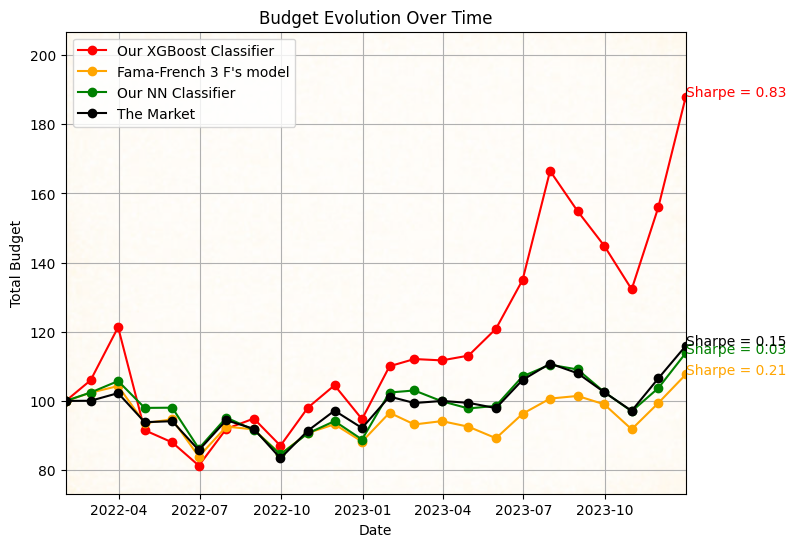

In [24]:
# Load the transparent JPEG image
image_path = 'beige.jpg'  # Replace with the path to your JPEG image
img = Image.open(image_path)

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Set plot limits based on your data
ax.set_xlim([reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max()])
ax.set_ylim([reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1])

# Resize the image to match the plot size
fig_width, fig_height = fig.get_size_inches() * fig.dpi
img_resized = img.resize((int(fig_width), int(fig_height)))

# Plot the image in the background with transparency (alpha)
ax.imshow(img_resized, aspect='auto', extent=[reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max(),
                                              reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1],
          alpha=0.4)  # Adjust alpha for transparency

# Plot the budget evolution
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_pred_prob'], marker='o', color='red', label='Our XGBoost Classifier')
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_y_pred_fama'], marker='o', color='orange', label="Fama-French 3 F's model")
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_y_pred_NN'], marker='o', color='green', label="Our NN Classifier")
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_market_portfolio'], marker='o', color='black', label='The Market')

# Add Sharpe ratios to the plot next to each line
sharpe_labels = {
    'budget_pred_prob': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_pred_prob","Sharpe Ratio"]),
    'budget_market_portfolio': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_market_portfolio","Sharpe Ratio"]),
    'budget_y_pred_fama': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_y_pred_fama","Sharpe Ratio"]),
    'budget_y_pred_NN': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_y_pred_NN","Sharpe Ratio"])
}

# Place the Sharpe ratio labels near the end of the lines
for label, line in zip(sharpe_labels.keys(), ax.lines):
    x_pos = reshaped_budget_df['date'].iloc[-1]  # Position the label at the last date
    y_pos = line.get_ydata()[-1]  # Get the last y value of the line
    ax.text(x_pos, y_pos, sharpe_labels[label], color=line.get_color(), fontsize=10, ha='left')

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Total Budget')
ax.set_title('Budget Evolution Over Time')
ax.grid(True)
ax.legend(loc='upper left')

# Show the plot
plt.show()


# Robustness checks

## 1.1 Comparison with a XGBoost algorithm on a regression setting

### Data Preparation

In [25]:
RETRAIN = False
if RETRAIN:
    df = pd.read_csv("GFD_final.csv")
    # Convert to datetime
    df['eom'] = pd.to_datetime(df['eom'])
    # Splitting the data by year for the different sets
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(df,"y", 2018, 2021, 2022, 2023)
    ids = ["excntry","gvkey","permno", "split"]
    X_train.drop(columns=ids, inplace=True)
    X_val.drop(columns=ids, inplace=True)
    X_test.drop(columns=ids, inplace=True)

    ff3 = pd.read_csv("factors_ff_clean.csv")
    X_train["year_month"] = X_train.eom.dt.year.astype(str) + "-" + X_train.eom.dt.month.astype(str) + "-01"
    X_val["year_month"] = X_val.eom.dt.year.astype(str) + "-" + X_val.eom.dt.month.astype(str) + "-01"
    X_test["year_month"] = X_test.eom.dt.year.astype(str) + "-" + X_test.eom.dt.month.astype(str) + "-01"
    
    
    X_train["year_month"] = pd.to_datetime(X_train["year_month"])
    X_val["year_month"] = pd.to_datetime(X_val["year_month"])
    X_test["year_month"] = pd.to_datetime(X_test["year_month"])
    
    ff3.date = pd.to_datetime(ff3.date)
    X_train = pd.merge(X_train,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_val = pd.merge(X_val,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_test = pd.merge(X_test,ff3, left_on = "year_month", right_on = "date", how = "left")
    
    X_train.drop(columns=["eom","year_month"], inplace = True)
    X_val.drop(columns=["eom","year_month"], inplace = True)
    X_test.drop(columns=["eom","year_month"], inplace = True)

    # Concatenate to apply the preprocessing function
    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    # Apply preprocessing
    train = preprocess(train)
    val = preprocess(val)
    test = preprocess(test)

    train.to_csv("train_1.csv", index=False)
    val.to_csv("val_1.csv", index=False)
    test.to_csv("test_1.csv", index=False)

    
else:
    train = pd.read_csv("train_1.csv")
    val = pd.read_csv("val_1.csv")
    test = pd.read_csv("test_1.csv")

In [26]:
train_ret_mean = train["ret"].mean()
train_y_mean = train["y"].mean()

val_ret_mean = val["ret"].mean()
val_y_mean = val["y"].mean()

test_ret_mean = test["ret"].mean()
test_y_mean = test["y"].mean()

# Create the DataFrame
pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "ret_mean": [train_ret_mean, val_ret_mean, test_ret_mean],
    "y_mean": [train_y_mean, val_y_mean, test_y_mean]
})

,Dataset,ret_mean,y_mean
0,Train,0.018703,0.014459
1,Validation,0.020932,0.014296
2,Test,0.003959,0.007675


Arranging X and y

In [27]:
y_train = train["y"]
X_train = train.drop(columns=["y","date"])

y_val = val["y"]
X_val = val.drop(columns=["y","date"])

y_test = test["y"]
X_test = test.drop(columns=["y", "date"])

Ensuring the number of features is the same for each set

In [28]:
# If columns are not matching it means that is because one of the industry' categories is not represented
common_columns = set(X_train.columns) & set(X_val.columns) & set(X_test.columns)

# Subset each DataFrame to include only the common columns
X_train = X_train[list(common_columns)]
X_val = X_val[list(common_columns)]
X_test = X_test[list(common_columns)]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(254833, 166) (254833,)
(44105, 166) (44105,)
(21874, 166) (21874,)


In [29]:
print("Total observations", X_train.shape[0]+X_val.shape[0]+X_test.shape[0])
print("Unique Stocks:", pd.concat([X_train,X_val,X_test], axis=0).id.nunique())

Total observations 320812
Unique Stocks: 3210


### Model Training (Predicting returns higher than 20%)

In [30]:
RETRAIN = False

if RETRAIN:
    param_grid_xgb = {
        "objective" : ["reg:squarederror"],
        "max_depth" : [2,3,4,5],
        "subsample" : [0.6,0.8],
        "n_estimators" : [2000],
        "learning_rate" : [0.001, 0.01,0.1],
        "reg_alpha" : [0],
        "reg_lambda" : [1],
        "eval_metric": ["rmse"],
        "colsample_bytree" : [0.6],
        "colsample_bylevel" : [0.8],
        "colsample_bynode": [0.6],
        'scale_pos_weight': [2],
        'min_child_weight': [1],
        "tree_method": ["hist"],
        "device": ["cuda"],
    }
    
    best_model = None
    best_score = float('inf')
    best_rounds = None
    
    # Total number of iterations for reporting progress
    total_iterations = (
        len(param_grid_xgb["max_depth"]) *
        len(param_grid_xgb["subsample"]) *
        len(param_grid_xgb["learning_rate"]) * 
        len(param_grid_xgb["reg_alpha"]) *
        len(param_grid_xgb["reg_lambda"]) 
    )
    
    # Counter for iteration number
    iteration_counter = 0
    
    # Grid search loop (manual)
    for max_depth in param_grid_xgb["max_depth"]:
        for subsample in param_grid_xgb["subsample"]:
            for learning_rate in param_grid_xgb["learning_rate"]:
                for reg_alpha in param_grid_xgb["reg_alpha"]:
                    for reg_lambda in param_grid_xgb["reg_lambda"]:
                        iteration_counter += 1
            
                        # Create model with current hyperparameters
                        model = XGBRegressor(
                            objective="reg:squarederror",
                            max_depth=max_depth,
                            subsample=subsample,
                            n_estimators=20000,
                            learning_rate=learning_rate,
                            reg_alpha = reg_alpha,
                            reg_lambda = reg_lambda,
                            eval_metric="rmse",
                            colsample_bytree=0.8,
                            colsample_bylevel=0.8,
                            colsample_bynode=0.8,
                            device="cuda",
                            random_state=28,
                            early_stopping_rounds=300
                        )
                        
                        # Train the model with early stopping
                        model.fit(
                            X_train, y_train, 
                            eval_set=[(X_val, y_val)], 
                            verbose=False
                        )
            
                        # Get the number of boosting rounds
                        best_rounds = model.best_iteration
                        
                        # Evaluate the model on the validation set
                        y_val_pred = model.predict(X_val)
                        score = mean_squared_error(y_val, y_val_pred)
                        
                        # Check if the current model is the best
                        if score < best_score:
                            best_score = score
                            best_model = model
            
                        # Print the current iteration details
                        print(f"Iteration {iteration_counter}/{total_iterations}: "
                              f"max_depth={max_depth}, subsample={subsample}, "
                              f"learning_rate={learning_rate}"
                              f"reg_alpha={reg_alpha}, reg_lambda={reg_lambda}, "
                              f"rounds={best_rounds}, \nValidation MSE={score:.7f}")
    
    # Now you have the best model trained with hyperparameters that were validated using the validation set
    print("\nBest model found with validation MSE:", best_score)

    # Save the best model
    best_model.save_model("xgboost_reg_22_23.json")
    
    # Save hyperparameters to a JSON file
    hyperparameters = best_model.get_params()
    with open("xgboost_reg_22_23_params.json", "w") as f:
        json.dump(hyperparameters, f)

else:
    best_model = XGBRegressor()
    best_model.load_model("xgboost_reg_22_23.json")

In [31]:
# Get the feature names from the loaded model
feature_names = best_model.get_booster().feature_names

# Encode column names as strings
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Reorder sets' columns to match the feature names order
X_train = X_train[feature_names]
X_val = X_val[feature_names]
X_test = X_test[feature_names]

In [32]:
# Predict on the train, validation, and test sets
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

results_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "MSE": [train_mse, val_mse, test_mse],
    "R2 Score": [train_r2, val_r2, test_r2]
})
results_df

,Dataset,MSE,R2 Score
0,Train,0.010119,0.176228
1,Validation,0.011613,0.037882
2,Test,0.013616,-0.039636


### Adding Fama-French 3 factors' model as a benchmark

In [33]:
RETRAIN = False

if RETRAIN:
    # Combine training and validation data
    X = pd.concat([X_train, X_val], axis=0, ignore_index=True)[['Mkt-RF', 'SMB', 'HML','RF']].reset_index(drop=True)
    y = pd.concat([train["y"], val["y"]], axis=0, ignore_index=True).reset_index(drop=True)
    # Taking out the RF in the outcome variable as in the model:
    y = y - (X["RF"]/100)
    # Removing RF from the factors:
    X.drop(columns="RF", inplace=True)
    
    ids = pd.concat([X_train, X_val], axis=0, ignore_index=True)['id'].reset_index(drop=True)
    
    # Add a constant for the intercept
    X = sm.add_constant(X)
    
    # Combine data into a single DataFrame for grouping
    data = pd.concat([X, y, ids], axis=1)
    data.columns = ['const', 'Mkt-RF', 'SMB', 'HML', 'y', 'id']
    
    # Initialize a list to store the results
    beta_results = []
    
    # Group by each stock's id and perform regression
    for stock_id, group in data.groupby('id'):
        # Extract X and y for the current stock
        X_stock = group[['const', 'Mkt-RF', 'SMB', 'HML']]
        y_stock = group['y']
        
        # Fit the regression model
        model = sm.OLS(y_stock, X_stock).fit()
        
        # Store the stock ID and the coefficients
        beta_results.append({
            'id': stock_id,
            'intercept': model.params['const'],
            'beta_Mkt-RF': model.params['Mkt-RF'],
            'beta_SMB': model.params['SMB'],
            'beta_HML': model.params['HML']
        })
    
    # Create a summary DataFrame
    beta_df = pd.DataFrame(beta_results)
    print(beta_df.shape)
    # Dimensions are matching:
    ids_train = set(train.id.unique()).union(set(val.id.unique()))
    print(len(ids_train))
    
    print(beta_df.head(2))

    # Merge the beta coefficients into the test set based on stock ID
    test_fama = pd.merge(test, beta_df, on='id', how='left')
    
    # Compute the predicted returns for merged observations only
    test_fama['y_pred_fama'] = (
        test_fama['intercept'] +
        test_fama['beta_Mkt-RF'] * test_fama['Mkt-RF'] +
        test_fama['beta_SMB'] * test_fama['SMB'] +
        test_fama['beta_HML'] * test_fama['HML']
    )
    
    # If no merge occurred (coefficients are NaN), keep predictions as NaN
    test_fama['y_pred_fama'] = test_fama['y_pred_fama'].where(test_fama['intercept'].notna(), None)

    test_fama["y_pred_fama"] = test_fama["y_pred_fama"].apply(lambda x: None if x==0 else x)
    ids_test = set(test_fama.id.unique())
    print(f"Out of the {len(ids_test)} ids in the test period, {len(ids_test.intersection(ids_train))} were also in the training period and hence have already estimated betas")

    # Exporting to csv
    y_pred_fama = test_fama["y_pred_fama"]
    y_pred_fama.to_csv("test_1_fama_pred.csv", index=False)

else:
    y_pred_fama = pd.read_csv("test_1_fama_pred.csv")

### Building a portfolio where each month we buy the 2% of stocks most likely to do an upward movement, proportionally according to budget

In [34]:
# Setting the dataframe
test["y_pred_fama"] = y_pred_fama
test.sort_values(by="date", ascending=True, inplace=True)
test.columns = test.columns.astype(str)
id_cols = ["y", "date"]
features = [col for col in test.columns if col not in id_cols]
test = test[id_cols+features]

# Predictions on the test set
test["pred_reg"] = best_model.predict(test[features][X_train.columns])
test.head(2)

,y,date,id,me,ret_6_1,ret_12_1,tax_gr1a,prc_highprc_252d,be_me,debt_me,...,43.0,44.0,45.0,46.0,47.0,48.0,49.0,missing,y_pred_fama,pred_reg
0,0.079306,2022-01-01,10026.0,0.000779,0.389042,0.382916,0.495357,0.785461,0.197979,0.007802,...,False,False,False,False,False,False,False,False,-0.074619,0.039714
3241,-0.052359,2022-01-01,14987.0,0.131818,0.396720,0.495336,0.462293,0.843510,0.748194,0.244358,...,False,False,False,False,False,False,False,False,-0.003603,0.014372


In [35]:
# Your test DataFrame and dates
dates = sorted(df.eom.unique())[-23:]
prediction_columns = ["pred_reg", "y_pred_fama"]
end_time = pd.Timestamp('2023-12-31')

# Compute reshaped budget DataFrame
reshaped_budget_df = compute_budget_evolution_reshaped(test, prediction_columns, dates, end_time)

# Display the DataFrame
reshaped_budget_df


,date,budget_market_portfolio,budget_rf,budget_pred_reg,budget_y_pred_fama,RF
0,2022-01-31,100.000000,100.000000,100.000000,100.000000,0.0000
1,2022-02-28,100.053193,100.000000,106.551949,102.386013,0.0000
2,2022-03-31,102.262271,100.000000,116.968358,104.310251,0.0000
3,2022-04-30,93.858492,100.000000,105.895524,93.573689,0.0000
4,2022-05-31,94.143229,100.000000,110.465920,94.674529,0.0003
5,2022-06-30,85.748382,100.000300,109.077983,83.897372,0.0006
6,2022-07-31,94.430097,100.000900,123.409696,92.571564,0.0008
7,2022-08-31,91.929696,100.001700,126.683819,91.781304,0.0019
8,2022-09-30,83.417413,100.003600,112.190503,84.589207,0.0019
9,2022-10-31,91.408937,100.005500,118.492692,90.735885,0.0023


In [36]:
# Apply to the given budget DataFrame
annual_metrics = compute_annual_metrics(reshaped_budget_df)
annual_metrics

,Annual Return,Annual Volatility,Sharpe Ratio,Annual Risk-Free Rate
budget_market_portfolio,0.076733,0.223267,0.206252,0.030684
budget_pred_reg,0.739304,0.358735,1.975328,0.030684
budget_y_pred_fama,0.037537,0.221239,0.030976,0.030684


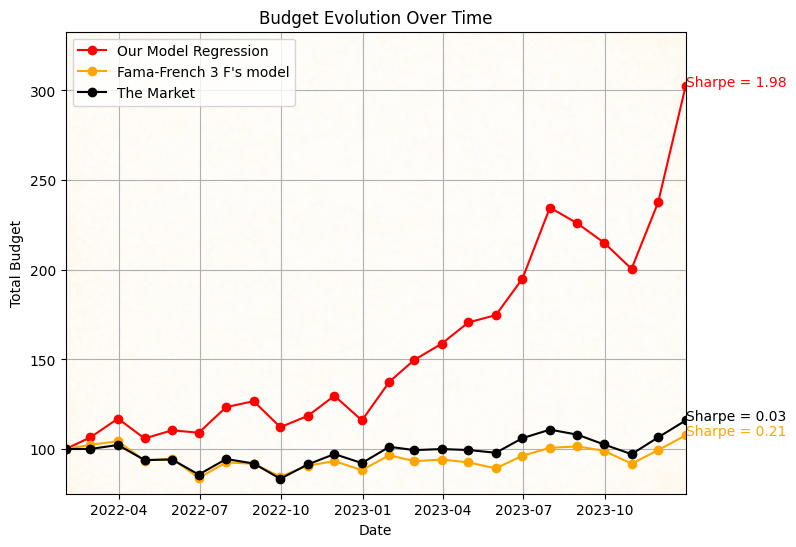

In [37]:
# Load the transparent JPEG image
image_path = 'beige.jpg'  # Replace with the path to your JPEG image
img = Image.open(image_path)

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Set plot limits based on your data
ax.set_xlim([reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max()])
ax.set_ylim([reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1])

# Resize the image to match the plot size
fig_width, fig_height = fig.get_size_inches() * fig.dpi
img_resized = img.resize((int(fig_width), int(fig_height)))

# Plot the image in the background with transparency (alpha)
ax.imshow(img_resized, aspect='auto', extent=[reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max(),
                                              reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1],
          alpha=0.4)  # Adjust alpha for transparency

# Plot the budget evolution
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_pred_reg'], marker='o', color='red', label='Our Model Regression')
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_y_pred_fama'], marker='o', color='orange', label="Fama-French 3 F's model")
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_market_portfolio'], marker='o', color='black', label='The Market')

# Add Sharpe ratios to the plot next to each line
sharpe_labels = {
    'budget_pred_reg': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_pred_reg","Sharpe Ratio"]),
    'budget_market_portfolio': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_market_portfolio","Sharpe Ratio"]),
    'budget_y_pred_fama': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_y_pred_fama","Sharpe Ratio"]),
}

# Place the Sharpe ratio labels near the end of the lines
for label, line in zip(sharpe_labels.keys(), ax.lines):
    x_pos = reshaped_budget_df['date'].iloc[-1]  # Position the label at the last date
    y_pos = line.get_ydata()[-1]  # Get the last y value of the line
    ax.text(x_pos, y_pos, sharpe_labels[label], color=line.get_color(), fontsize=10, ha='left')

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Total Budget')
ax.set_title('Budget Evolution Over Time')
ax.grid(True)
ax.legend(loc='upper left')

# Show the plot
plt.show()


## 1.2 Comparison with a XGBoost model trained using CV (determining which one is best between Binary and Regression setting)

### Model Training (Predicting returns higher than 20%)

In [38]:
RETRAIN = False

if RETRAIN:
    # Define the parameter grid
    param_grid_xgb = {
        "objective" : ["reg:squarederror"],
        "max_depth" : [2,3,4,5],
        "subsample" : [0.6,0.8],
        "n_estimators" : [2000],
        "learning_rate" : [0.001, 0.01,0.1],
        "reg_alpha" : [0],
        "reg_lambda" : [1],
        "eval_metric": ["rmse"],
        "colsample_bytree" : [0.6],
        "colsample_bylevel" : [0.8],
        "colsample_bynode": [0.6],
        'scale_pos_weight': [2],
        'min_child_weight': [1],
        "tree_method": ["hist"],
        "device": ["cuda"],
    }
    
    # Define the model
    xgb_model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=2000,
        eval_metric="rmse",
        random_state=28,
        early_stopping_rounds=300
    )
    
    # Define the scoring metric
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid_xgb,
        scoring=scorer,
        cv=5,  # 5-fold cross-validation
        verbose=4,
        n_jobs=-1,  # Use all available processors
        refit=True,
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    
    # Log the best results
    print(f"\nBest Validation MSE: {best_score:.7f}")
    print(f"Best Parameters: {best_params}")
    # Save the best model
    best_model.save_model("xgboost_regcv_22_23.json")
    
    # Save hyperparameters to a JSON file
    hyperparameters = best_model.get_params()
    with open("xgboost_regcv_22_23_params.json", "w") as f:
        json.dump(hyperparameters, f)

else:
    best_model = XGBRegressor()
    best_model.load_model("xgboost_regcv_22_23.json")

In [39]:
# Get the feature names from the loaded model
feature_names = best_model.get_booster().feature_names

# Encode column names as strings
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Reorder sets' columns to match the feature names order
X_train = X_train[feature_names]
X_val = X_val[feature_names]
X_test = X_test[feature_names]

In [40]:
# Predict on the train, validation, and test sets
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

results_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "MSE": [train_mse, val_mse, test_mse],
    "R2 Score": [train_r2, val_r2, test_r2]
})
results_df

,Dataset,MSE,R2 Score
0,Train,0.010162,0.172714
1,Validation,0.011822,0.020515
2,Test,0.013493,-0.030260


### Adding Fama-French 3 factors' model as a benchmark

In [41]:
RETRAIN = False

if RETRAIN:
    # Combine training and validation data
    X = pd.concat([X_train, X_val], axis=0, ignore_index=True)[['Mkt-RF', 'SMB', 'HML','RF']].reset_index(drop=True)
    y = pd.concat([train["y"], val["y"]], axis=0, ignore_index=True).reset_index(drop=True)
    # Taking out the RF in the outcome variable as in the model:
    y = y - (X["RF"]/100)
    # Removing RF from the factors:
    X.drop(columns="RF", inplace=True)
    
    ids = pd.concat([X_train, X_val], axis=0, ignore_index=True)['id'].reset_index(drop=True)
    
    # Add a constant for the intercept
    X = sm.add_constant(X)
    
    # Combine data into a single DataFrame for grouping
    data = pd.concat([X, y, ids], axis=1)
    data.columns = ['const', 'Mkt-RF', 'SMB', 'HML', 'y', 'id']
    
    # Initialize a list to store the results
    beta_results = []
    
    # Group by each stock's id and perform regression
    for stock_id, group in data.groupby('id'):
        # Extract X and y for the current stock
        X_stock = group[['const', 'Mkt-RF', 'SMB', 'HML']]
        y_stock = group['y']
        
        # Fit the regression model
        model = sm.OLS(y_stock, X_stock).fit()
        
        # Store the stock ID and the coefficients
        beta_results.append({
            'id': stock_id,
            'intercept': model.params['const'],
            'beta_Mkt-RF': model.params['Mkt-RF'],
            'beta_SMB': model.params['SMB'],
            'beta_HML': model.params['HML']
        })
    
    # Create a summary DataFrame
    beta_df = pd.DataFrame(beta_results)
    print(beta_df.shape)
    # Dimensions are matching:
    ids_train = set(train.id.unique()).union(set(val.id.unique()))
    print(len(ids_train))
    
    print(beta_df.head(2))

    # Merge the beta coefficients into the test set based on stock ID
    test_fama = pd.merge(test, beta_df, on='id', how='left')
    
    # Compute the predicted returns for merged observations only
    test_fama['y_pred_fama'] = (
        test_fama['intercept'] +
        test_fama['beta_Mkt-RF'] * test_fama['Mkt-RF'] +
        test_fama['beta_SMB'] * test_fama['SMB'] +
        test_fama['beta_HML'] * test_fama['HML']
    )
    
    # If no merge occurred (coefficients are NaN), keep predictions as NaN
    test_fama['y_pred_fama'] = test_fama['y_pred_fama'].where(test_fama['intercept'].notna(), None)

    test_fama["y_pred_fama"] = test_fama["y_pred_fama"].apply(lambda x: None if x==0 else x)
    ids_test = set(test_fama.id.unique())
    print(f"Out of the {len(ids_test)} ids in the test period, {len(ids_test.intersection(ids_train))} were also in the training period and hence have already estimated betas")

    # Exporting to csv
    y_pred_fama = test_fama["y_pred_fama"]
    y_pred_fama.to_csv("test_1_fama_pred.csv", index=False)

else:
    y_pred_fama = pd.read_csv("test_1_fama_pred.csv")

### Building a portfolio where each month we buy the 2% of stocks most likely to do an upward movement, proportionally according to budget

In [42]:
# Setting the dataframe
test["y_pred_fama"] = y_pred_fama
test.sort_values(by="date", ascending=True, inplace=True)
test.columns = test.columns.astype(str)
id_cols = ["y", "date"]
features = [col for col in test.columns if col not in id_cols]
test = test[id_cols+features]

# Predictions on the test set
test["pred_reg"] = best_model.predict(test[features][X_train.columns])
test.head(2)

,y,date,id,me,ret_6_1,ret_12_1,tax_gr1a,prc_highprc_252d,be_me,debt_me,...,43.0,44.0,45.0,46.0,47.0,48.0,49.0,missing,y_pred_fama,pred_reg
0,0.079306,2022-01-01,10026.0,0.000779,0.389042,0.382916,0.495357,0.785461,0.197979,0.007802,...,False,False,False,False,False,False,False,False,-0.074619,0.027228
7108,-0.144235,2022-01-01,19403.0,0.007349,0.531569,0.484793,0.522367,0.808439,0.020627,0.241132,...,False,False,False,False,False,False,False,False,NaN,0.015153


In [43]:
# Your test DataFrame and dates
dates = sorted(df.eom.unique())[-23:]
prediction_columns = ["pred_reg", "y_pred_fama"]
end_time = pd.Timestamp('2023-12-31')

# Compute reshaped budget DataFrame
reshaped_budget_df = compute_budget_evolution_reshaped(test, prediction_columns, dates, end_time)

# Display the DataFrame
reshaped_budget_df


,date,budget_market_portfolio,budget_rf,budget_pred_reg,budget_y_pred_fama,RF
0,2022-01-31,100.000000,100.000000,100.000000,100.000000,0.0000
1,2022-02-28,100.053193,100.000000,107.849507,102.386013,0.0000
2,2022-03-31,102.262271,100.000000,116.798855,104.310251,0.0000
3,2022-04-30,93.858492,100.000000,112.040744,93.573689,0.0000
4,2022-05-31,94.143229,100.000000,118.034414,94.674529,0.0003
5,2022-06-30,85.748382,100.000300,112.794404,83.897372,0.0006
6,2022-07-31,94.430097,100.000900,129.136678,92.571564,0.0008
7,2022-08-31,91.929696,100.001700,135.049031,91.781304,0.0019
8,2022-09-30,83.417413,100.003600,122.053089,84.589207,0.0019
9,2022-10-31,91.408937,100.005500,138.613626,90.735885,0.0023


In [44]:
# Apply to the given budget DataFrame
annual_metrics = compute_annual_metrics(reshaped_budget_df)
annual_metrics

,Annual Return,Annual Volatility,Sharpe Ratio,Annual Risk-Free Rate
budget_market_portfolio,0.076733,0.223267,0.206252,0.030684
budget_pred_reg,0.983716,0.362829,2.626668,0.030684
budget_y_pred_fama,0.037537,0.221239,0.030976,0.030684


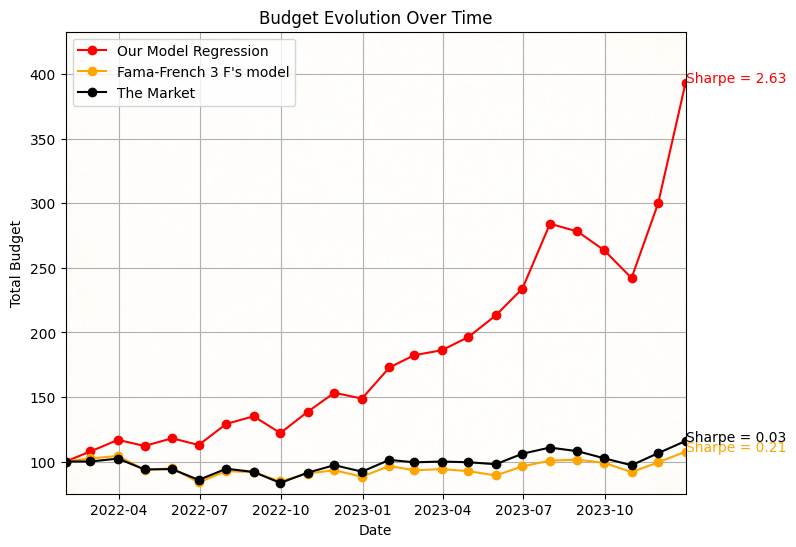

In [46]:
# Load the transparent JPEG image
image_path = 'beige.jpg'  # Replace with the path to your JPEG image
img = Image.open(image_path)

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Set plot limits based on your data
ax.set_xlim([reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max()])
ax.set_ylim([reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1])

# Resize the image to match the plot size
fig_width, fig_height = fig.get_size_inches() * fig.dpi
img_resized = img.resize((int(fig_width), int(fig_height)))

# Plot the image in the background with transparency (alpha)
ax.imshow(img_resized, aspect='auto', extent=[reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max(),
                                              reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1],
          alpha=0.2)  # Adjust alpha for transparency

# Plot the budget evolution
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_pred_reg'], marker='o', color='red', label='Our Model Regression')
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_y_pred_fama'], marker='o', color='orange', label="Fama-French 3 F's model")
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_market_portfolio'], marker='o', color='black', label='The Market')

# Add Sharpe ratios to the plot next to each line
sharpe_labels = {
    'budget_pred_reg': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_pred_reg","Sharpe Ratio"]),
    'budget_market_portfolio': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_market_portfolio","Sharpe Ratio"]),
    'budget_y_pred_fama': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_y_pred_fama","Sharpe Ratio"]),
}

# Place the Sharpe ratio labels near the end of the lines
for label, line in zip(sharpe_labels.keys(), ax.lines):
    x_pos = reshaped_budget_df['date'].iloc[-1]  # Position the label at the last date
    y_pos = line.get_ydata()[-1]  # Get the last y value of the line
    ax.text(x_pos, y_pos, sharpe_labels[label], color=line.get_color(), fontsize=10, ha='left')

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Total Budget')
ax.set_title('Budget Evolution Over Time')
ax.grid(True)
ax.legend(loc='upper left')

# Show the plot
plt.show()


## Trying with different years

## Time Period 2: 
- Train (1995-2015)
- Val (2016-2019)
- Test (2020-2021)

### Data Preparation

In [47]:
RETRAIN = False
if RETRAIN:
    df = pd.read_csv("GFD_final.csv")
    # Convert to datetime
    df['eom'] = pd.to_datetime(df['eom'])
    # Splitting the data by year for the different sets
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(df,"y", 2016, 2019, 2020, 2021)
    ids = ["excntry","gvkey","permno", "split"]
    X_train.drop(columns=ids, inplace=True)
    X_val.drop(columns=ids, inplace=True)
    X_test.drop(columns=ids, inplace=True)

    ff3 = pd.read_csv("factors_ff_clean.csv")
    X_train["year_month"] = X_train.eom.dt.year.astype(str) + "-" + X_train.eom.dt.month.astype(str) + "-01"
    X_val["year_month"] = X_val.eom.dt.year.astype(str) + "-" + X_val.eom.dt.month.astype(str) + "-01"
    X_test["year_month"] = X_test.eom.dt.year.astype(str) + "-" + X_test.eom.dt.month.astype(str) + "-01"
    
    
    X_train["year_month"] = pd.to_datetime(X_train["year_month"])
    X_val["year_month"] = pd.to_datetime(X_val["year_month"])
    X_test["year_month"] = pd.to_datetime(X_test["year_month"])
    
    ff3.date = pd.to_datetime(ff3.date)
    X_train = pd.merge(X_train,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_val = pd.merge(X_val,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_test = pd.merge(X_test,ff3, left_on = "year_month", right_on = "date", how = "left")
    
    X_train.drop(columns=["eom","year_month"], inplace = True)
    X_val.drop(columns=["eom","year_month"], inplace = True)
    X_test.drop(columns=["eom","year_month"], inplace = True)

    # Concatenate to apply the preprocessing function
    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    # Apply preprocessing
    train = preprocess(train)
    val = preprocess(val)
    test = preprocess(test)

    train.to_csv("train_2.csv", index=False)
    val.to_csv("val_2.csv", index=False)
    test.to_csv("test_2.csv", index=False)

    
else:
    train = pd.read_csv("train_2.csv")
    val = pd.read_csv("val_2.csv")
    test = pd.read_csv("test_2.csv")

Descriptive of the outcome

In [48]:
train["target"] = (train["y"] > 0.2).astype(int)
val["target"] = (val["y"] > 0.2).astype(int)
test["target"] = (test["y"] > 0.2).astype(int)
percentage_train = (train.target.sum() / train.shape[0]) * 100
print(f"Target Percentage Train: {percentage_train:.2f}%")
percentage_val = (val.target.sum() / val.shape[0]) * 100
print(f"Target Percentage Val: {percentage_val:.2f}%")
percentage_test = (test.target.sum() / test.shape[0]) * 100
print(f"Target Percentage Test: {percentage_test:.2f}%")

Target Percentage Train: 4.25%
Target Percentage Val: 2.04%
Target Percentage Test: 6.04%


Arranging X and y

In [49]:
y_train = train["target"]
X_train = train.drop(columns=["y","target","date"])

y_val = val["target"]
X_val = val.drop(columns=["y","target","date"])

y_test = test["target"]
X_test = test.drop(columns=["y","target", "date"])

Ensuring the number of features is the same for each set

In [50]:
# If columns are not matching it means that is because one of the industry' categories is not represented
common_columns = set(X_train.columns) & set(X_val.columns) & set(X_test.columns)

# Subset each DataFrame to include only the common columns
X_train = X_train[list(common_columns)]
X_val = X_val[list(common_columns)]
X_test = X_test[list(common_columns)]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(231237, 165) (231237,)
(41522, 165) (41522,)
(22002, 165) (22002,)


In [51]:
print("Total observations", X_train.shape[0]+X_val.shape[0]+X_test.shape[0])
print("Unique Stocks:", pd.concat([X_train,X_val,X_test], axis=0).id.nunique())

Total observations 294761
Unique Stocks: 3051


### Model Training (Predicting returns higher than 20%)

In [52]:
RETRAIN = False

if RETRAIN:
    param_grid_xgb = {
        "objective": ["binary:logistic"],
        "max_depth": [2,3,4,5],
        "subsample": [0.6,0.8],
        "n_estimators": [20000],
        "learning_rate": [0.001, 0.01,0.1],
        "reg_alpha": [0],
        "reg_lambda": [1],
        "eval_metric": ["logloss"],
        "colsample_bytree": [0.8],
        "colsample_bylevel": [0.8],
        "colsample_bynode": [0.8],
        "tree_method": ["hist"],
        "device": ["cuda"],
    }
    
    best_model = None
    best_logloss = float('inf')
    best_auc = 0.0
    best_rounds = None
    
    # Total number of iterations for reporting progress
    total_iterations = (
        len(param_grid_xgb["max_depth"]) *
        len(param_grid_xgb["subsample"]) *
        len(param_grid_xgb["learning_rate"]) * 
        len(param_grid_xgb["reg_alpha"]) *
        len(param_grid_xgb["reg_lambda"]) 
    )
    
    # Counter for iteration number
    iteration_counter = 0
    
    # Grid search loop (manual)
    for max_depth in param_grid_xgb["max_depth"]:
        for subsample in param_grid_xgb["subsample"]:
            for learning_rate in param_grid_xgb["learning_rate"]:
                for reg_alpha in param_grid_xgb["reg_alpha"]:
                    for reg_lambda in param_grid_xgb["reg_lambda"]:
                        iteration_counter += 1
            
                        # Create model with current hyperparameters
                        model = XGBClassifier(
                            objective="binary:logistic",
                            max_depth=max_depth,
                            subsample=subsample,
                            n_estimators= 20000,
                            learning_rate=learning_rate,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            eval_metric="logloss",
                            colsample_bytree=0.8,
                            colsample_bylevel=0.8,
                            colsample_bynode=0.8,
                            device="cuda",
                            random_state=28,
                            early_stopping_rounds=300
                        )
                        
                        # Train the model with early stopping
                        model.fit(
                            X_train, y_train, 
                            eval_set=[(X_val, y_val)], 
                            verbose=False
                        )
            
                        # Get the number of boosting rounds
                        best_rounds = model.best_iteration
                        
                        # Evaluate the model on the validation set
                        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
                        logloss = log_loss(y_val, y_val_pred_proba)
                        auc = roc_auc_score(y_val, y_val_pred_proba)
                        
                        # Check if the current model is the best
                        if auc > best_auc:
                            best_logloss = logloss
                            best_auc = auc
                            best_model = model
            
                        # Print the current iteration details
                        print(f"Iteration {iteration_counter}/{total_iterations}: "
                              f"max_depth={max_depth}, subsample={subsample}, "
                              f"learning_rate={learning_rate}, "
                              f"reg_alpha={reg_alpha}, reg_lambda={reg_lambda}, "
                              f"rounds={best_rounds}, \nValidation LogLoss={logloss:.7f}, AUC={auc:.7f}")
    
    # Now you have the best model trained with hyperparameters validated using the validation set
    print("\nBest model found with validation LogLoss:", best_logloss)
    print("Best model found with validation AUC:", best_auc)

    # Save the best model
    best_model.save_model("xgboost_bin_20_21.json")
    
    # Save hyperparameters to a JSON file
    hyperparameters = best_model.get_params()
    with open("xgboost_bin_20_21_params.json", "w") as f:
        json.dump(hyperparameters, f)

else:
    # Load the model from the saved file
    best_model = XGBClassifier()
    best_model.load_model("xgboost_bin_20_21.json")


In [53]:
# Get the feature names from the loaded model
feature_names = best_model.get_booster().feature_names

# Encode column names as strings
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Reorder sets' columns to match the feature names order
X_train = X_train[feature_names]
X_val = X_val[feature_names]
X_test = X_test[feature_names]

In [54]:
# Predicted probabilities and true labels
y_val_probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0, 1.01, 0.01)

# Initialize variables to track the best threshold
best_threshold = 0
best_f1 = 0

# Loop over thresholds to compute F1-scores
for threshold in thresholds:
    y_val_pred = (y_val_probs > threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Optimal Threshold: 0.1700
Best F1-Score: 0.1577


### Results

In [55]:
# Train predictions
X_train = X_train[feature_names]
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_pred_proba >= best_threshold).astype(int)

# Val predictions
X_val = X_val[feature_names]
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= best_threshold).astype(int)

# Test predictions
X_test = X_test[feature_names]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

In [56]:
train_precision = precision_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Create the DataFrame
data_desc = {
    "Metric": ["Precision", "Accuracy", "F1-score"],
    "Train": [train_precision, train_accuracy, train_f1],
    "Validation": [val_precision, val_accuracy, val_f1],
    "Test": [test_precision, test_accuracy, test_f1]
}

df_desc = pd.DataFrame(data_desc)
df_desc

,Metric,Train,Validation,Test
0,Precision,0.350394,0.110377,0.248235
1,Accuracy,0.942933,0.939815,0.920144
2,F1-score,0.374893,0.157735,0.193667


In [57]:
# Create a DataFrame to store probabilities and actual values
results_df = pd.DataFrame({
    "Predicted_Proba": y_test_pred_proba,
    "Actual_Value": y_test
})

# Sort the DataFrame by predicted probabilities in descending order
results_df_sorted = results_df.sort_values(by="Predicted_Proba", ascending=False)

# Get the top 1000 and bottom 1000 predicted probabilities and their actual values
top_1000 = results_df_sorted.head(1000)
bottom_1000 = results_df_sorted.tail(1000)

# Calculate statistics for evaluation TOP
num_actual_positives_top = top_1000["Actual_Value"].sum()
proportion_positives_top = num_actual_positives_top / len(top_1000)

# Calculate statistics for evaluation BOTTOM
num_actual_positives_bottom = bottom_1000["Actual_Value"].sum()
proportion_positives_bottom = num_actual_positives_bottom / len(bottom_1000)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    "Group": ["Top 1000 Predictions", "Bottom 1000 Predictions"],
    "Actual Positives": [num_actual_positives_top, num_actual_positives_bottom],
    "Proportion Positives": [proportion_positives_top, proportion_positives_bottom]
})

# Display the summary DataFrame
summary_df

,Group,Actual Positives,Proportion Positives
0,Top 1000 Predictions,244,0.244
1,Bottom 1000 Predictions,0,0.000


In [58]:
best_1000 = top_1000.index
bottom_1000 = bottom_1000.index
a = test["y"]
b = test["y"].iloc[best_1000]
c = test["y"].iloc[bottom_1000]

In [59]:
# Create the DataFrame
desc = {
    "Statistic": ["Mean Returns (%)", "Min Returns (%)", "Max Returns (%)", "Standard Deviation (%)"],
    "Market": [
        a.mean() * 100,
        a.min() * 100,
        a.max() * 100,
        a.std() * 100
    ],
    "Top_1000": [
        b.mean() * 100,
        b.min() * 100,
        b.max() * 100,
        b.std() * 100
    ],
    "Bottom_1000": [
        c.mean() * 100,
        c.min() * 100,
        c.max() * 100,
        c.std() * 100
    ],
}

df_desc = pd.DataFrame(desc)

# Display the DataFrame
df_desc

,Statistic,Market,Top_1000,Bottom_1000
0,Mean Returns (%),1.959196,9.006874,-0.671523
1,Min Returns (%),-71.974087,-39.746296,-22.454172
2,Max Returns (%),141.000748,141.000748,19.384392
3,Standard Deviation (%),12.362091,21.668820,6.690894


### Adding Fama-French 3 factors' model as a benchmark

In [60]:
RETRAIN = True

if RETRAIN:
    # Combine training and validation data
    X = pd.concat([X_train, X_val], axis=0, ignore_index=True)[['Mkt-RF', 'SMB', 'HML','RF']].reset_index(drop=True)
    y = pd.concat([train["y"], val["y"]], axis=0, ignore_index=True).reset_index(drop=True)
    # Taking out the RF in the outcome variable as in the model:
    y = y - (X["RF"]/100)
    # Removing RF from the factors:
    X.drop(columns="RF", inplace=True)
    
    ids = pd.concat([X_train, X_val], axis=0, ignore_index=True)['id'].reset_index(drop=True)
    
    # Add a constant for the intercept
    X = sm.add_constant(X)
    
    # Combine data into a single DataFrame for grouping
    data = pd.concat([X, y, ids], axis=1)
    data.columns = ['const', 'Mkt-RF', 'SMB', 'HML', 'y', 'id']
    
    # Initialize a list to store the results
    beta_results = []
    
    # Group by each stock's id and perform regression
    for stock_id, group in data.groupby('id'):
        # Extract X and y for the current stock
        X_stock = group[['const', 'Mkt-RF', 'SMB', 'HML']]
        y_stock = group['y']
        
        # Fit the regression model
        model = sm.OLS(y_stock, X_stock).fit()
        
        # Store the stock ID and the coefficients
        beta_results.append({
            'id': stock_id,
            'intercept': model.params['const'],
            'beta_Mkt-RF': model.params['Mkt-RF'],
            'beta_SMB': model.params['SMB'],
            'beta_HML': model.params['HML']
        })
    
    # Create a summary DataFrame
    beta_df = pd.DataFrame(beta_results)
    print(beta_df.shape)
    # Dimensions are matching:
    ids_train = set(train.id.unique()).union(set(val.id.unique()))
    print(len(ids_train))
    
    print(beta_df.head(2))

    # Merge the beta coefficients into the test set based on stock ID
    test_fama = pd.merge(test, beta_df, on='id', how='left')
    
    # Compute the predicted returns for merged observations only
    test_fama['y_pred_fama'] = (
        test_fama['intercept'] +
        test_fama['beta_Mkt-RF'] * test_fama['Mkt-RF'] +
        test_fama['beta_SMB'] * test_fama['SMB'] +
        test_fama['beta_HML'] * test_fama['HML']
    )
    
    # If no merge occurred (coefficients are NaN), keep predictions as NaN
    test_fama['y_pred_fama'] = test_fama['y_pred_fama'].where(test_fama['intercept'].notna(), None)

    test_fama["y_pred_fama"] = test_fama["y_pred_fama"].apply(lambda x: None if x==0 else x)
    ids_test = set(test_fama.id.unique())
    print(f"Out of the {len(ids_test)} ids in the test period, {len(ids_test.intersection(ids_train))} were also in the training period and hence have already estimated betas")

    # Exporting to csv
    y_pred_fama = test_fama["y_pred_fama"]
    y_pred_fama.to_csv("test_2_fama_pred.csv", index=False)

else:
    y_pred_fama = pd.read_csv("test_2_fama_pred.csv")

(2841, 5)
2841
        id  intercept  beta_Mkt-RF  beta_SMB  beta_HML
0  10026.0   0.099998     0.000893 -0.172570 -0.042139
1  10032.0   0.056312     0.030313  0.042837 -0.086970
Out of the 1112 ids in the test period, 902 were also in the training period and hence have already estimated betas


### Building a portfolio where each month we buy the 2% of stocks most likely to do an upward movement, proportionally according to budget

In [61]:
# Setting the dataframe
test["y_pred_fama"] = y_pred_fama
test.sort_values(by="date", ascending=True, inplace=True)
test.columns = test.columns.astype(str)
id_cols = ["y", "target", "date"]
features = [col for col in test.columns if col not in id_cols]
test = test[id_cols+features]

# Predictions on the test set
test["pred_prob"] = best_model.predict_proba(test[features][X_train.columns])[:, 1]
test.head(1)

,y,target,date,id,me,ret_6_1,ret_12_1,tax_gr1a,prc_highprc_252d,be_me,...,43.0,44.0,45.0,46.0,47.0,48.0,49.0,missing,y_pred_fama,pred_prob
0,-0.03027,0,2020-01-01,10026.0,0.001789,0.239349,0.196309,0.637388,0.752726,0.16218,...,False,False,False,False,False,False,False,False,0.017261,0.016129


In [62]:
# Your test DataFrame and dates
dates = sorted(df.eom.unique())[-71:-47]
prediction_columns = ["pred_prob", "y_pred_fama"]
end_time = pd.Timestamp('2020-01-31')

# Compute reshaped budget DataFrame
reshaped_budget_df = compute_budget_evolution_reshaped(test, prediction_columns, dates, end_time)

# Display the DataFrame
reshaped_budget_df


,date,budget_market_portfolio,budget_rf,budget_pred_prob,budget_y_pred_fama,RF
0,2018-01-31,100.000000,100.0000,100.000000,100.000000,0.0013
1,2018-02-28,92.350668,100.0013,103.840452,95.785397,0.0012
2,2018-03-31,76.139270,100.0025,86.694421,80.700191,0.0012
3,2018-04-30,88.081327,100.0037,128.563255,100.244232,0.0000
4,2018-05-31,95.381545,100.0037,146.699708,110.343371,0.0001
5,2018-06-30,97.988469,100.0038,165.722769,119.527577,0.0001
6,2018-07-31,103.585261,100.0039,171.608364,134.178149,0.0001
7,2018-08-31,109.036292,100.0040,193.453840,133.024139,0.0001
8,2018-09-30,106.631850,100.0041,181.099649,126.909200,0.0001
9,2018-10-31,107.049902,100.0042,175.386258,134.253528,0.0001


In [63]:
# Apply to the given budget DataFrame
annual_metrics = compute_annual_metrics(reshaped_budget_df)
annual_metrics

,Annual Return,Annual Volatility,Sharpe Ratio,Annual Risk-Free Rate
budget_market_portfolio,0.226700,0.243829,0.920309,0.002302
budget_pred_prob,0.838105,0.572751,1.459276,0.002302
budget_y_pred_fama,0.286484,0.297579,0.954979,0.002302


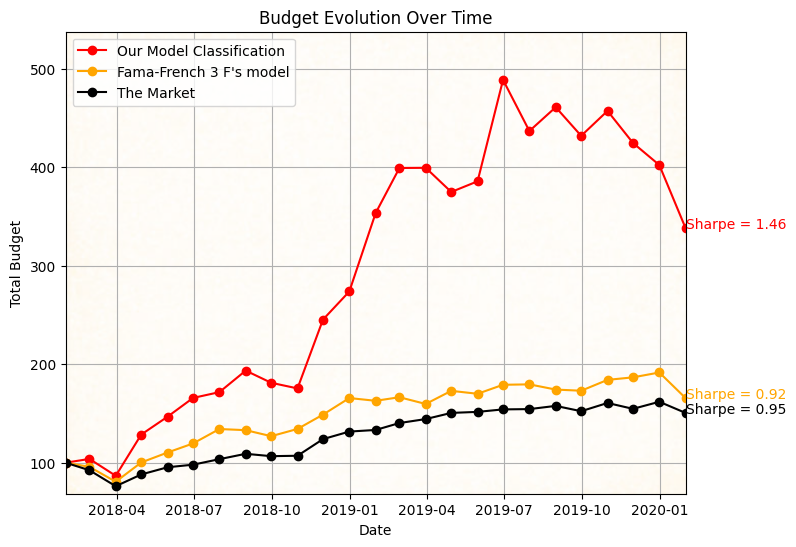

In [64]:
# Load the transparent JPEG image
image_path = 'beige.jpg'  # Replace with the path to your JPEG image
img = Image.open(image_path)

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Set plot limits based on your data
ax.set_xlim([reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max()])
ax.set_ylim([reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1])

# Resize the image to match the plot size
fig_width, fig_height = fig.get_size_inches() * fig.dpi
img_resized = img.resize((int(fig_width), int(fig_height)))

# Plot the image in the background with transparency (alpha)
ax.imshow(img_resized, aspect='auto', extent=[reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max(),
                                              reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1],
          alpha=0.4)  # Adjust alpha for transparency

# Plot the budget evolution
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_pred_prob'], marker='o', color='red', label='Our Model Classification')
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_y_pred_fama'], marker='o', color='orange', label="Fama-French 3 F's model")
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_market_portfolio'], marker='o', color='black', label='The Market')

# Add Sharpe ratios to the plot next to each line
sharpe_labels = {
    'budget_pred_prob': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_pred_prob","Sharpe Ratio"]),
    'budget_market_portfolio': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_market_portfolio","Sharpe Ratio"]),
    'budget_y_pred_fama': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_y_pred_fama","Sharpe Ratio"]),
}

# Place the Sharpe ratio labels near the end of the lines
for label, line in zip(sharpe_labels.keys(), ax.lines):
    x_pos = reshaped_budget_df['date'].iloc[-1]  # Position the label at the last date
    y_pos = line.get_ydata()[-1]  # Get the last y value of the line
    ax.text(x_pos, y_pos, sharpe_labels[label], color=line.get_color(), fontsize=10, ha='left')

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Total Budget')
ax.set_title('Budget Evolution Over Time')
ax.grid(True)
ax.legend(loc='upper left')

# Show the plot
plt.show()


## Time Period 3: 
- Train (1995-2013)
- Val (2014-2017)
- Test (2018-2019)

### Data Preparation

Retrain the below if you want to preprocess the data again for that time period

In [65]:
RETRAIN = False
if RETRAIN:
    df = pd.read_csv("GFD_final.csv")
    # Convert to datetime
    df['eom'] = pd.to_datetime(df['eom'])
    # Splitting the data by year for the different sets
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(df,"y", 2014, 2017, 2018,2019)
    ids = ["excntry","gvkey","permno", "split"]
    X_train.drop(columns=ids, inplace=True)
    X_val.drop(columns=ids, inplace=True)
    X_test.drop(columns=ids, inplace=True)

    ff3 = pd.read_csv("factors_ff_clean.csv")
    X_train["year_month"] = X_train.eom.dt.year.astype(str) + "-" + X_train.eom.dt.month.astype(str) + "-01"
    X_val["year_month"] = X_val.eom.dt.year.astype(str) + "-" + X_val.eom.dt.month.astype(str) + "-01"
    X_test["year_month"] = X_test.eom.dt.year.astype(str) + "-" + X_test.eom.dt.month.astype(str) + "-01"
    
    
    X_train["year_month"] = pd.to_datetime(X_train["year_month"])
    X_val["year_month"] = pd.to_datetime(X_val["year_month"])
    X_test["year_month"] = pd.to_datetime(X_test["year_month"])
    
    ff3.date = pd.to_datetime(ff3.date)
    X_train = pd.merge(X_train,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_val = pd.merge(X_val,ff3, left_on = "year_month", right_on = "date", how = "left")
    X_test = pd.merge(X_test,ff3, left_on = "year_month", right_on = "date", how = "left")
    
    X_train.drop(columns=["eom","year_month"], inplace = True)
    X_val.drop(columns=["eom","year_month"], inplace = True)
    X_test.drop(columns=["eom","year_month"], inplace = True)

    # Concatenate to apply the preprocessing function
    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    # Apply preprocessing
    train = preprocess(train)
    val = preprocess(val)
    test = preprocess(test)

    train.to_csv("train_3.csv", index=False)
    val.to_csv("val_3.csv", index=False)
    test.to_csv("test_3.csv", index=False)
    
else:
    train = pd.read_csv("train_3.csv")
    val = pd.read_csv("val_3.csv")
    test = pd.read_csv("test_3.csv")

Descriptive of the outcome

In [66]:
train["target"] = (train["y"] > 0.2).astype(int)
val["target"] = (val["y"] > 0.2).astype(int)
test["target"] = (test["y"] > 0.2).astype(int)
percentage_train = (train.target.sum() / train.shape[0]) * 100
print(f"Target Percentage Train: {percentage_train:.2f}%")
percentage_val = (val.target.sum() / val.shape[0]) * 100
print(f"Target Percentage Val: {percentage_val:.2f}%")
percentage_test = (test.target.sum() / test.shape[0]) * 100
print(f"Target Percentage Test: {percentage_test:.2f}%")

Target Percentage Train: 4.55%
Target Percentage Val: 1.73%
Target Percentage Test: 2.13%


Arranging X and y

In [67]:
y_train = train["target"]
X_train = train.drop(columns=["y","target","date"])

y_val = val["target"]
X_val = val.drop(columns=["y","target","date"])

y_test = test["target"]
X_test = test.drop(columns=["y","target", "date"])

Ensuring the number of features is the same for each set

In [68]:
# If columns are not matching it means that is because one of the industry' categories is not represented
common_columns = set(X_train.columns) & set(X_val.columns) & set(X_test.columns)

# Subset each DataFrame to include only the common columns
X_train = X_train[list(common_columns)]
X_val = X_val[list(common_columns)]
X_test = X_test[list(common_columns)]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(207744, 165) (207744,)
(41487, 165) (41487,)
(19653, 165) (19653,)


In [69]:
print("Total observations", X_train.shape[0]+X_val.shape[0]+X_test.shape[0])
print("Unique Stocks:", pd.concat([X_train,X_val,X_test], axis=0).id.nunique())

Total observations 268884
Unique Stocks: 2838


### Model Training (Predicting returns higher than 20%)

In [70]:
RETRAIN = False

if RETRAIN:
    param_grid_xgb = {
        "objective": ["binary:logistic"],
        "max_depth": [2,3,4,5],
        "subsample": [0.6,0.8],
        "n_estimators": [20000],
        "learning_rate": [0.001, 0.01,0.1],
        "reg_alpha": [0],
        "reg_lambda": [1],
        "eval_metric": ["logloss"],
        "colsample_bytree": [0.8],
        "colsample_bylevel": [0.8],
        "colsample_bynode": [0.8],
        "tree_method": ["hist"],
        "device": ["cuda"],
    }
    
    best_model = None
    best_logloss = float('inf')
    best_auc = 0.0
    best_rounds = None
    
    # Total number of iterations for reporting progress
    total_iterations = (
        len(param_grid_xgb["max_depth"]) *
        len(param_grid_xgb["subsample"]) *
        len(param_grid_xgb["learning_rate"]) * 
        len(param_grid_xgb["reg_alpha"]) *
        len(param_grid_xgb["reg_lambda"]) 
    )
    
    # Counter for iteration number
    iteration_counter = 0
    
    # Grid search loop (manual)
    for max_depth in param_grid_xgb["max_depth"]:
        for subsample in param_grid_xgb["subsample"]:
            for learning_rate in param_grid_xgb["learning_rate"]:
                for reg_alpha in param_grid_xgb["reg_alpha"]:
                    for reg_lambda in param_grid_xgb["reg_lambda"]:
                        iteration_counter += 1
            
                        # Create model with current hyperparameters
                        model = XGBClassifier(
                            objective="binary:logistic",
                            max_depth=max_depth,
                            subsample=subsample,
                            n_estimators= 20000,
                            learning_rate=learning_rate,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            eval_metric="logloss",
                            colsample_bytree=0.8,
                            colsample_bylevel=0.8,
                            colsample_bynode=0.8,
                            device="cuda",
                            random_state=28,
                            early_stopping_rounds=300
                        )
                        
                        # Train the model with early stopping
                        model.fit(
                            X_train, y_train, 
                            eval_set=[(X_val, y_val)], 
                            verbose=False
                        )
            
                        # Get the number of boosting rounds
                        best_rounds = model.best_iteration
                        
                        # Evaluate the model on the validation set
                        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
                        logloss = log_loss(y_val, y_val_pred_proba)
                        auc = roc_auc_score(y_val, y_val_pred_proba)
                        
                        # Check if the current model is the best
                        if auc > best_auc:
                            best_logloss = logloss
                            best_auc = auc
                            best_model = model
            
                        # Print the current iteration details
                        print(f"Iteration {iteration_counter}/{total_iterations}: "
                              f"max_depth={max_depth}, subsample={subsample}, "
                              f"learning_rate={learning_rate}, "
                              f"reg_alpha={reg_alpha}, reg_lambda={reg_lambda}, "
                              f"rounds={best_rounds}, \nValidation LogLoss={logloss:.7f}, AUC={auc:.7f}")
    
    # Now you have the best model trained with hyperparameters validated using the validation set
    print("\nBest model found with validation LogLoss:", best_logloss)
    print("Best model found with validation AUC:", best_auc)

    # Save the best model
    best_model.save_model("xgboost_bin_18_19.json")
    
    # Save hyperparameters to a JSON file
    hyperparameters = best_model.get_params()
    with open("xgboost_bin_18_19_params.json", "w") as f:
        json.dump(hyperparameters, f)

else:
    # Load the model from the saved file
    best_model = XGBClassifier()
    best_model.load_model("xgboost_bin_18_19.json")


In [71]:
# Get the feature names from the loaded model
feature_names = best_model.get_booster().feature_names

# Encode column names as strings
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Reorder sets' columns to match the feature names order
X_train = X_train[feature_names]
X_val = X_val[feature_names]
X_test = X_test[feature_names]

In [72]:
# Predicted probabilities and true labels
y_val_probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0, 1.01, 0.01)

# Initialize variables to track the best threshold
best_threshold = 0
best_f1 = 0

# Loop over thresholds to compute F1-scores
for threshold in thresholds:
    y_val_pred = (y_val_probs > threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Optimal Threshold: 0.1900
Best F1-Score: 0.1686


### Results

In [73]:
# Train predictions
X_train = X_train[feature_names]
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_pred_proba >= best_threshold).astype(int)

# Val predictions
X_val = X_val[feature_names]
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= best_threshold).astype(int)

# Test predictions
X_test = X_test[feature_names]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

In [74]:
train_precision = precision_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Create the DataFrame
data_desc = {
    "Metric": ["Precision", "Accuracy", "F1-score"],
    "Train": [train_precision, train_accuracy, train_f1],
    "Validation": [val_precision, val_accuracy, val_f1],
    "Test": [test_precision, test_accuracy, test_f1]
}

df_desc = pd.DataFrame(data_desc)
df_desc

,Metric,Train,Validation,Test
0,Precision,0.360793,0.110072,0.070258
1,Accuracy,0.940528,0.938439,0.903984
2,F1-score,0.377676,0.168620,0.112835


In [75]:
# Create a DataFrame to store probabilities and actual values
results_df = pd.DataFrame({
    "Predicted_Proba": y_test_pred_proba,
    "Actual_Value": y_test
})

# Sort the DataFrame by predicted probabilities in descending order
results_df_sorted = results_df.sort_values(by="Predicted_Proba", ascending=False)

# Get the top 1000 and bottom 1000 predicted probabilities and their actual values
top_1000 = results_df_sorted.head(1000)
bottom_1000 = results_df_sorted.tail(1000)

# Calculate statistics for evaluation TOP
num_actual_positives_top = top_1000["Actual_Value"].sum()
proportion_positives_top = num_actual_positives_top / len(top_1000)

# Calculate statistics for evaluation BOTTOM
num_actual_positives_bottom = bottom_1000["Actual_Value"].sum()
proportion_positives_bottom = num_actual_positives_bottom / len(bottom_1000)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    "Group": ["Top 1000 Predictions", "Bottom 1000 Predictions"],
    "Actual Positives": [num_actual_positives_top, num_actual_positives_bottom],
    "Proportion Positives": [proportion_positives_top, proportion_positives_bottom]
})

# Display the summary DataFrame
summary_df

,Group,Actual Positives,Proportion Positives
0,Top 1000 Predictions,73,0.073
1,Bottom 1000 Predictions,0,0.000


In [76]:
best_1000 = top_1000.index
bottom_1000 = bottom_1000.index
a = test["y"]
b = test["y"].iloc[best_1000]
c = test["y"].iloc[bottom_1000]

In [77]:
# Create the DataFrame
desc = {
    "Statistic": ["Mean Returns (%)", "Min Returns (%)", "Max Returns (%)", "Standard Deviation (%)"],
    "Market": [
        a.mean() * 100,
        a.min() * 100,
        a.max() * 100,
        a.std() * 100
    ],
    "Top_1000": [
        b.mean() * 100,
        b.min() * 100,
        b.max() * 100,
        b.std() * 100
    ],
    "Bottom_1000": [
        c.mean() * 100,
        c.min() * 100,
        c.max() * 100,
        c.std() * 100
    ],
}

df_desc = pd.DataFrame(desc)

# Display the DataFrame
df_desc

,Statistic,Market,Top_1000,Bottom_1000
0,Mean Returns (%),0.838185,1.783545,0.459791
1,Min Returns (%),-53.356594,-39.435676,-24.961522
2,Max Returns (%),82.297140,51.361221,17.624354
3,Standard Deviation (%),9.056903,12.704223,5.099608


### Adding Fama-French 3 factors' model as a benchmark

In [78]:
RETRAIN = False

if RETRAIN:
    # Combine training and validation data
    X = pd.concat([X_train, X_val], axis=0, ignore_index=True)[['Mkt-RF', 'SMB', 'HML','RF']].reset_index(drop=True)
    y = pd.concat([train["y"], val["y"]], axis=0, ignore_index=True).reset_index(drop=True)
    # Taking out the RF in the outcome variable as in the model:
    y = y - (X["RF"]/100)
    # Removing RF from the factors:
    X.drop(columns="RF", inplace=True)
    
    ids = pd.concat([X_train, X_val], axis=0, ignore_index=True)['id'].reset_index(drop=True)
    
    # Add a constant for the intercept
    X = sm.add_constant(X)
    
    # Combine data into a single DataFrame for grouping
    data = pd.concat([X, y, ids], axis=1)
    data.columns = ['const', 'Mkt-RF', 'SMB', 'HML', 'y', 'id']
    
    # Initialize a list to store the results
    beta_results = []
    
    # Group by each stock's id and perform regression
    for stock_id, group in data.groupby('id'):
        # Extract X and y for the current stock
        X_stock = group[['const', 'Mkt-RF', 'SMB', 'HML']]
        y_stock = group['y']
        
        # Fit the regression model
        model = sm.OLS(y_stock, X_stock).fit()
        
        # Store the stock ID and the coefficients
        beta_results.append({
            'id': stock_id,
            'intercept': model.params['const'],
            'beta_Mkt-RF': model.params['Mkt-RF'],
            'beta_SMB': model.params['SMB'],
            'beta_HML': model.params['HML']
        })
    
    # Create a summary DataFrame
    beta_df = pd.DataFrame(beta_results)
    print(beta_df.shape)
    # Dimensions are matching:
    ids_train = set(train.id.unique()).union(set(val.id.unique()))
    print(len(ids_train))
    
    print(beta_df.head(2))

    # Merge the beta coefficients into the test set based on stock ID
    test_fama = pd.merge(test, beta_df, on='id', how='left')
    
    # Compute the predicted returns for merged observations only
    test_fama['y_pred_fama'] = (
        test_fama['intercept'] +
        test_fama['beta_Mkt-RF'] * test_fama['Mkt-RF'] +
        test_fama['beta_SMB'] * test_fama['SMB'] +
        test_fama['beta_HML'] * test_fama['HML']
    )
    
    # If no merge occurred (coefficients are NaN), keep predictions as NaN
    test_fama['y_pred_fama'] = test_fama['y_pred_fama'].where(test_fama['intercept'].notna(), None)

    test_fama["y_pred_fama"] = test_fama["y_pred_fama"].apply(lambda x: None if x==0 else x)
    ids_test = set(test_fama.id.unique())
    print(f"Out of the {len(ids_test)} ids in the test period, {len(ids_test.intersection(ids_train))} were also in the training period and hence have already estimated betas")

    # Exporting to csv
    y_pred_fama = test_fama["y_pred_fama"]
    y_pred_fama.to_csv("test_3_fama_pred.csv", index=False)

else:
    y_pred_fama = pd.read_csv("test_3_fama_pred.csv")

### Building a portfolio where each month we buy the 2% of stocks most likely to do an upward movement, proportionally according to budget

In [79]:
# Setting the dataframe
test["y_pred_fama"] = y_pred_fama
test.sort_values(by="date", ascending=True, inplace=True)
test.columns = test.columns.astype(str)
id_cols = ["y", "target", "date"]
features = [col for col in test.columns if col not in id_cols]
test = test[id_cols+features]

# Predictions on the test set
test["pred_prob"] = best_model.predict_proba(test[features][X_train.columns])[:, 1]
test.head(1)

,y,target,date,id,me,ret_6_1,ret_12_1,tax_gr1a,prc_highprc_252d,be_me,...,43.0,44.0,45.0,46.0,47.0,48.0,49.0,missing,pred_prob,y_pred_fama
0,0.042429,0,2018-01-01,84788.0,1.0,0.558005,0.515047,0.518995,1.0,0.016413,...,True,False,False,False,False,False,False,False,0.011207,0.041853


In [80]:
# Your test DataFrame and dates
dates = sorted(df.eom.unique())[-71:-47]
prediction_columns = ["pred_prob", "y_pred_fama"]
end_time = pd.Timestamp('2020-01-31')

# Compute reshaped budget DataFrame
reshaped_budget_df = compute_budget_evolution_reshaped(test, prediction_columns, dates, end_time)

# Display the DataFrame
reshaped_budget_df


,date,budget_market_portfolio,budget_rf,budget_pred_prob,budget_y_pred_fama,RF
0,2018-01-31,100.000000,100.000000,100.000000,100.000000,0.0011
1,2018-02-28,96.386433,100.001100,93.723096,99.760798,0.0011
2,2018-03-31,96.244440,100.002200,95.920149,101.642958,0.0012
3,2018-04-30,96.450378,100.003400,93.755017,104.567193,0.0014
4,2018-05-31,99.597586,100.004800,105.670240,112.770225,0.0014
5,2018-06-30,100.448698,100.006200,110.886748,111.832452,0.0014
6,2018-07-31,103.193727,100.007600,111.343989,114.408161,0.0016
7,2018-08-31,106.650791,100.009200,131.999448,125.026582,0.0016
8,2018-09-30,106.460704,100.010801,134.161848,122.803712,0.0015
9,2018-10-31,97.042270,100.012301,114.194363,107.263059,0.0019


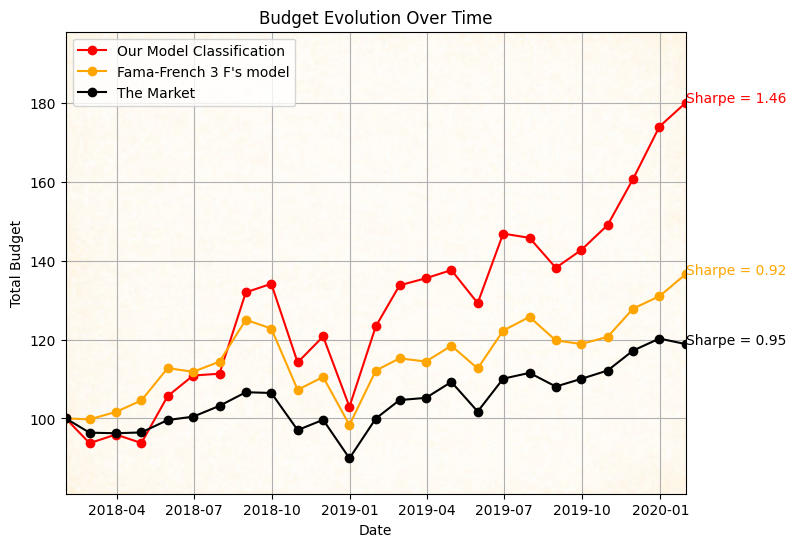

In [81]:
# Load the transparent JPEG image
image_path = 'beige.jpg'  # Replace with the path to your JPEG image
img = Image.open(image_path)

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Set plot limits based on your data
ax.set_xlim([reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max()])
ax.set_ylim([reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1])

# Resize the image to match the plot size
fig_width, fig_height = fig.get_size_inches() * fig.dpi
img_resized = img.resize((int(fig_width), int(fig_height)))

# Plot the image in the background with transparency (alpha)
ax.imshow(img_resized, aspect='auto', extent=[reshaped_budget_df['date'].min(), reshaped_budget_df['date'].max(),
                                              reshaped_budget_df.drop(columns=["date","RF"]).min().min() * 0.9, reshaped_budget_df.drop(columns=["date","RF"]).max().max() * 1.1],
          alpha=0.6)  # Adjust alpha for transparency

# Plot the budget evolution
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_pred_prob'], marker='o', color='red', label='Our Model Classification')
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_y_pred_fama'], marker='o', color='orange', label="Fama-French 3 F's model")
ax.plot(reshaped_budget_df['date'], reshaped_budget_df['budget_market_portfolio'], marker='o', color='black', label='The Market')

# Add Sharpe ratios to the plot next to each line
sharpe_labels = {
    'budget_pred_prob': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_pred_prob","Sharpe Ratio"]),
    'budget_market_portfolio': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_market_portfolio","Sharpe Ratio"]),
    'budget_y_pred_fama': 'Sharpe = {:.2f}'.format(annual_metrics.loc["budget_y_pred_fama","Sharpe Ratio"]),
}

# Place the Sharpe ratio labels near the end of the lines
for label, line in zip(sharpe_labels.keys(), ax.lines):
    x_pos = reshaped_budget_df['date'].iloc[-1]  # Position the label at the last date
    y_pos = line.get_ydata()[-1]  # Get the last y value of the line
    ax.text(x_pos, y_pos, sharpe_labels[label], color=line.get_color(), fontsize=10, ha='left')

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Total Budget')
ax.set_title('Budget Evolution Over Time')
ax.grid(True)
ax.legend(loc='upper left')

# Show the plot
plt.show()


# Describing model' characteristics

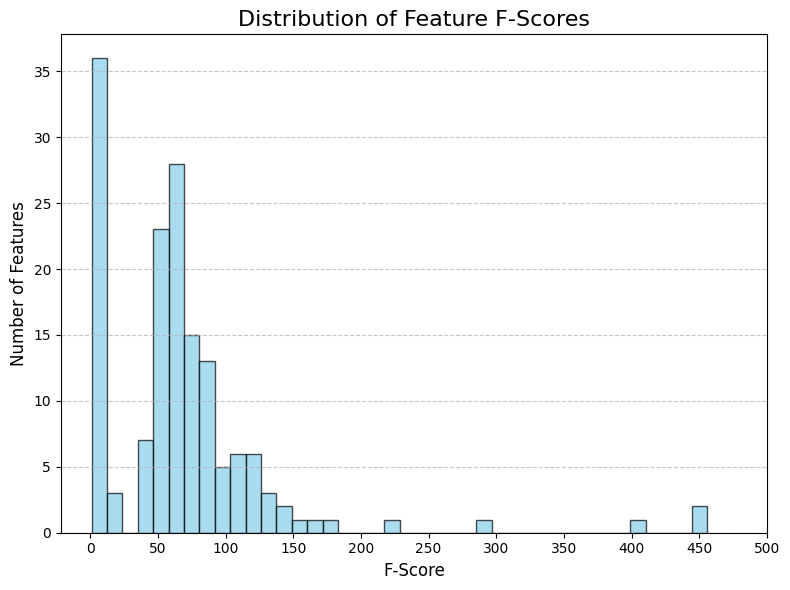

In [92]:
# Extract feature importance scores
feature_importances = best_model.get_booster().get_score(importance_type='weight')

# Convert to a DataFrame
importance_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['F-Score']).reset_index()
importance_df.columns = ['Feature', 'F-Score']

# Plot histogram of F-Scores
plt.figure(figsize=(8, 6))
plt.hist(importance_df['F-Score'], bins=40, color='skyblue', edgecolor='black', alpha=0.7)

# Customize x-axis with intervals of 20 starting from 0
max_fscore = importance_df['F-Score'].max()
xticks = np.arange(0, max_fscore + 50, 50)
plt.xticks(xticks, fontsize=10)

plt.title('Distribution of Feature F-Scores', fontsize=16)
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


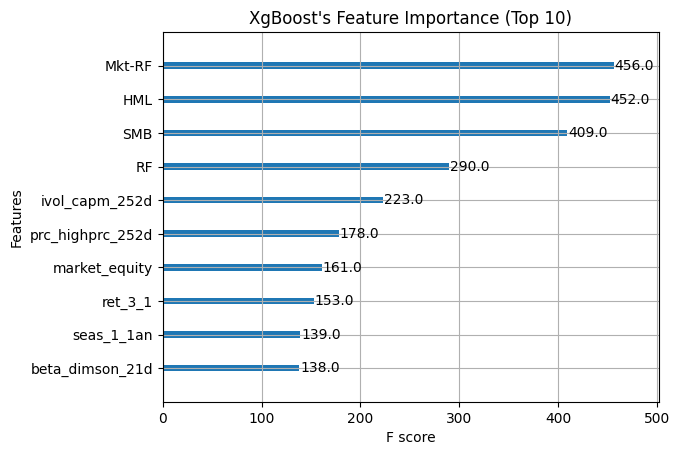

In [88]:
# Feature Importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("XgBoost's Feature Importance (Top 10)")
plt.show()

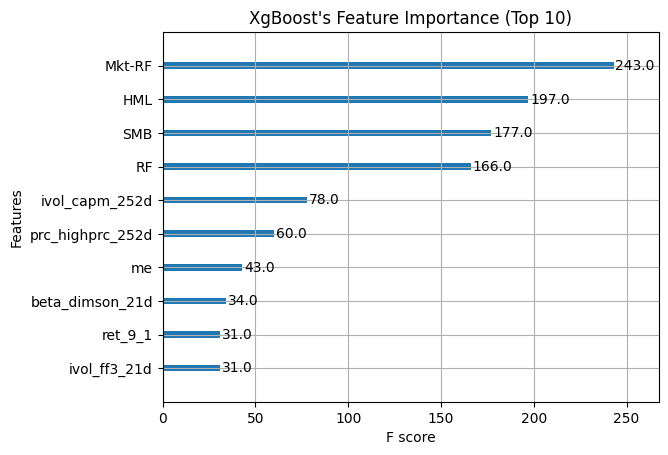

Feature Relative Importance:
div12m_me: 0.0043
8.0: 0.0004
14.0: 0.0004
15.0: 0.0009
16.0: 0.0004
19.0: 0.0004
25.0: 0.0004
27.0: 0.0026
28.0: 0.0021
coa_gr1a: 0.0047
seas_1_1na: 0.0068
Mkt-RF: 0.1038
dbnetis_at: 0.0038
29.0: 0.0026
31.0: 0.0030
fcf_me: 0.0056
35.0: 0.0030
lti_gr1a: 0.0060
36.0: 0.0009
kz_index: 0.0030
37.0: 0.0030
RF: 0.0709
40.0: 0.0004
41.0: 0.0021
42.0: 0.0004
niq_be: 0.0043
ncoa_gr1a: 0.0021
dolvol_126d: 0.0034
ivol_capm_252d: 0.0333
inv_gr1a: 0.0060
noa_gr1a: 0.0038
qmj_safety: 0.0038
aliq_at: 0.0038
dsale_drec: 0.0026
nfna_gr1a: 0.0068
rmax5_rvol_21d: 0.0090
iskew_ff3_21d: 0.0077
beta_dimson_21d: 0.0145
zero_trades_21d: 0.0013
cash_at: 0.0056
at_be: 0.0047
bidaskhl_21d: 0.0077
netis_at: 0.0034
cowc_gr1a: 0.0017
lnoa_gr1a: 0.0051
tangibility: 0.0038
ocf_at: 0.0051
eqnpo_me: 0.0098
be_me: 0.0030
op_at: 0.0064
ivol_hxz4_21d: 0.0060
ebit_bev: 0.0098
ebitda_mev: 0.0038
ami_126d: 0.0081
tax_gr1a: 0.0034
seas_1_1an: 0.0124
iskew_hxz4_21d: 0.0068
chcsho_12m: 0.0034
ni_b

In [27]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Feature Importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("XgBoost's Feature Importance (Top 10)")
plt.show()

# Extract feature importance as a dictionary
feature_importance = best_model.get_booster().get_score(importance_type='weight')

# Normalize the F-scores to get relative importance
total_f_score = sum(feature_importance.values())
relative_importance = {key: value / total_f_score for key, value in feature_importance.items()}

# Display the relative importance
print("Feature Relative Importance:")
for feature, importance in relative_importance.items():
    print(f"{feature}: {importance:.4f}")


In [38]:
sorted_dict = dict(sorted(relative_importance.items(), key=lambda item: item[1]))
#sorted_dict